In [1]:
### https://towardsdatascience.com/binary-classification-xgboost-hyperparameter-tuning-scenarios-by-non-exhaustive-grid-search-and-c261f4ce098d
### https://www.kaggle.com/code/prashant111/a-guide-on-xgboost-hyperparameters-tuning/notebook

#creating deepcopy of model instances
from copy import deepcopy

#array manipulations
import numpy as np

#dataframe and its manipulations
import pandas as pd

#plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

#selected plotting functions
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

#classes for grid search and cross-validation, function for splitting data and evaluating models
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV,train_test_split
from skopt import BayesSearchCV
from sklearn.metrics import accuracy_score,f1_score,roc_auc_score,confusion_matrix,roc_curve,recall_score,precision_score

#XGBoost library
import xgboost as xgb
from xgboost import plot_tree

#Python standard libraries
import time
import warnings

#Saving the model
import pickle

def gini(actual, pred):
    assert (len(actual) == len(pred))
    all = np.asarray(np.c_[actual, pred, np.arange(len(actual))], dtype=float)
    all = all[np.lexsort((all[:, 2], -1 * all[:, 1]))]
    totalLosses = all[:, 0].sum()
    giniSum = all[:, 0].cumsum().sum() / totalLosses

    giniSum -= (len(actual) + 1) / 2.
    return giniSum / len(actual)

def gini_normalized(actual, pred):
    return gini(actual, pred) / gini(actual, actual)

#setting default resolution of figures
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

In [2]:
growth_new = pd.read_csv("/home/johnpfeiffer/Venv/ganitumabResponse/ISPY2_NewGanitumab/BioMarkers_NewGanitumab/extracted/growth_rates.csv")
meta_new = pd.read_csv("/home/johnpfeiffer/Venv/ganitumabResponse/ISPY2_NewGanitumab/BioMarkers_NewGanitumab/extracted/meta.csv")
mvs_new = pd.read_csv("/home/johnpfeiffer/Venv/ganitumabResponse/ISPY2_NewGanitumab/BioMarkers_NewGanitumab/extracted/mvs.csv")
nutrients_new = pd.read_csv("/home/johnpfeiffer/Venv/ganitumabResponse/ISPY2_NewGanitumab/BioMarkers_NewGanitumab/extracted/nutrients.csv")
radio_new = pd.read_csv("/home/johnpfeiffer/Venv/ganitumabResponse/ISPY2_NewGanitumab/BioMarkers_NewGanitumab/extracted/radiomics.csv")
densities_new = pd.read_csv("/home/johnpfeiffer/Venv/ganitumabResponse/ISPY2_NewGanitumab/BioMarkers_NewGanitumab/extracted/shell_densities.csv")
morph_new = pd.read_csv("/home/johnpfeiffer/Venv/ganitumabResponse/ISPY2_NewGanitumab/BioMarkers_NewGanitumab/extracted/tumor_shapes.csv")

df0 = pd.concat([growth_new, meta_new], axis=1)
df1 = pd.concat([df0, mvs_new], axis=1)
df2 = pd.concat([df1, nutrients_new], axis=1)
df3 = pd.concat([df2, radio_new], axis=1)
df4 = pd.concat([df3, densities_new], axis=1)
df_new = pd.concat([df4, morph_new], axis=1)

In [3]:
growth_old = pd.read_csv("/home/johnpfeiffer/Venv/ganitumabResponse/ISPY2_OldGanitumab/BioMarkers_OldGanitumab/extracted/growth_rates.csv")
meta_old = pd.read_csv("/home/johnpfeiffer/Venv/ganitumabResponse/ISPY2_OldGanitumab/BioMarkers_OldGanitumab/extracted/meta.csv")
mvs_old = pd.read_csv("/home/johnpfeiffer/Venv/ganitumabResponse/ISPY2_OldGanitumab/BioMarkers_OldGanitumab/extracted/mvs.csv")
nutrients_old = pd.read_csv("/home/johnpfeiffer/Venv/ganitumabResponse/ISPY2_OldGanitumab/BioMarkers_OldGanitumab/extracted/nutrients.csv")
radio_old = pd.read_csv("/home/johnpfeiffer/Venv/ganitumabResponse/ISPY2_OldGanitumab/BioMarkers_OldGanitumab/extracted/radiomics.csv")
densities_old = pd.read_csv("/home/johnpfeiffer/Venv/ganitumabResponse/ISPY2_OldGanitumab/BioMarkers_OldGanitumab/extracted/shell_densities.csv")
morph_old = pd.read_csv("/home/johnpfeiffer/Venv/ganitumabResponse/ISPY2_OldGanitumab/BioMarkers_OldGanitumab/extracted/tumor_shapes.csv")

df0 = pd.concat([growth_old, meta_old], axis=1)
df1 = pd.concat([df0, mvs_old], axis=1)
df2 = pd.concat([df1, nutrients_old], axis=1)
df3 = pd.concat([df2, radio_old], axis=1)
df4 = pd.concat([df3, densities_old], axis=1)
df_old = pd.concat([df4, morph_old], axis=1)

In [4]:
sim = pd.concat([df_old, df_new])
sim = sim.dropna(subset=["caseID"])
sim = sim.drop(['exkey'], axis=1)
sim = sim.drop(['depictionID'], axis=1)
sim = sim.drop(['simID'], axis=1)
sim = sim.drop(['growth_rates'], axis=1)
sim = sim.drop(['radiomics'], axis=1)
sim = sim.drop(['nutrients'], axis=1)
sim = sim.loc[:,~sim.columns.duplicated()].copy()

In [5]:
clin_old = pd.read_csv("/home/johnpfeiffer/Venv/ganitumabResponse/ISPY2_OldGanitumab/SBS_OldGanitumab_DataEntry_07.27.22_JP.csv")
clin_new = pd.read_csv("/home/johnpfeiffer/Venv/ganitumabResponse/ISPY2_NewGanitumab/SBS_NewGanitumab_DataEntry_08.02.22_JP.csv")
clin = pd.concat([clin_old, clin_new])
clin['raceEthnicity'] = pd.Categorical(clin.raceEthnicity)
clin['fdaHR'] = pd.Categorical(clin.fdaHR)
clin['fdaHER2'] = pd.Categorical(clin.fdaHER2)
clin['mammaPrintIndex'] = pd.Categorical(clin.mammaPrintIndex)
clin['pathCompleteResponse'] = pd.Categorical(clin.pathCompleteResponse)

In [6]:
data = sim.merge(clin, on='caseID', how='left')
data = data.set_index("caseID")
data.index.names = [None]
nunique = data.nunique()
cols_to_drop = nunique[nunique == 1].index
data = data.drop(cols_to_drop, axis=1)
data = data.dropna(subset=["pathCompleteResponse"])

In [7]:
X, y = data.iloc[:,0:-1],data.iloc[:,-1]
X = pd.get_dummies(X)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=420, stratify=y)
X_test, X_validate, y_test, y_validate = train_test_split(X_test, y_test, test_size=0.5, random_state=420)

y_train = pd.get_dummies(y_train)
y_train = y_train[1].astype(bool)

y_test = pd.get_dummies(y_test)
y_test = y_test[1].astype(bool)

y_validate = pd.get_dummies(y_validate)
y_validate = y_validate[1].astype(bool)

In [16]:
y_test

ISPY2_0467-L    False
ISPY2_0263-R    False
ISPY2_0008-L    False
ISPY2_0783-R     True
ISPY2_0045-R    False
ISPY2_0060-L     True
ISPY2_0851-R    False
ISPY2_0191-L     True
ISPY2_0178-L     True
ISPY2_0058-R    False
ISPY2_0696-R    False
ISPY2_0283-R    False
ISPY2_0368-L    False
ISPY2_0029-R     True
ISPY2_0427-L    False
ISPY2_0704-L    False
ISPY2_0429-L    False
ISPY2_0096-R     True
ISPY2_0050-L    False
ISPY2_0070-L    False
ISPY2_0280-R     True
Name: True, dtype: bool

In [17]:
X_validate.to_csv("/home/johnpfeiffer/Venv/ganitumabResponse/ganitumab_untouched_validation.csv")
X_test.to_csv("/home/johnpfeiffer/Venv/ganitumabResponse/ganitumab_testing_set.csv")
X_train.to_csv("/home/johnpfeiffer/Venv/ganitumabResponse/ganitumab_training_set.csv")

In [18]:
### parameters for grid search
param_grid = {'gamma': [0,0.01,0.05,0.1,0.2,0.4,0.8,1.6,3.2,6.4],
              'learning_rate': [0.01,0.05,0.1,0.2,0.3,0.4,0.8,1.6,3.2,6.4],
              'n_estimators': [100,250,500,750,1000,1500],
              'reg_alpha': [0,0.01,0.05,0.1,0.2,0.4,0.8,1.0,1.6,3.2,6.4],
              'reg_lambda':  [0.01,0.05,0.1,0.2,0.4,0.8,1.0,1.6,3.2,6.4],
              'min_child_weight': [0.01,0.05,0.1,0.2,0.4,0.8,1.0,1.6,3.2,6.4],
              'scale_pos_weight': [0.01,0.05,0.1,0.2,0.4,0.8,1.0,1.6,3.2,6.4]}

In [19]:
#dictionary for collecting results
results_dict = {}
hyperparam = 'n_estimators'

for x in param_grid[hyperparam]:
    
    xgbc0 = xgb.XGBClassifier(objective='binary:logistic',
                          booster='gbtree',
                          eval_metric='error',
                          tree_method='hist',
                          grow_policy='lossguide',
                          use_label_encoder=False,
                          base_score=0.70,
                          max_depth=3,
                          n_estimators = x)#, 
                          #learning_rate = , 
                          #scale_pos_weight = , 
                          #min_child_weight = ,
                          #gamma = , 
                          #reg_lambda = , 
                          #reg_alpha = )
                            
    xgbc0.fit(X_train , y_train)

    #extracting default parameters from benchmark model
    default_params = {}
    gparams = xgbc0.get_params()

    #default parameters have to be wrapped in lists - even single values - so GridSearchCV can take them as inputs
    for key in gparams.keys():
        gp = gparams[key]
        default_params[key] = [gp]

    #benchmark model. Grid search is not performed, since only single values are provided as parameter grid.
    #However, cross-validation is still executed
    clf0 = GridSearchCV(estimator=xgbc0, scoring='f1', param_grid=default_params, return_train_score=True, verbose=0, cv=10, n_jobs=10)
    clf0.fit(X_train, y_train.values.ravel())
    test_predictions = clf0.predict(X_test)
    cfm_test = confusion_matrix(y_test, test_predictions)
    bp = clf0.best_params_

    #results
    TN = cfm_test[0,0]
    TP = cfm_test[1,1]
    FP = cfm_test[0,1]
    FN = cfm_test[1,0]
    specificity = TN / (TN + FP)
    sensitivity = TP / (TP + FN)
    ppv = TP / (TP + FP) 
    npv = TN / (TN + FN)
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    f1 = f1_score(y_test, test_predictions, pos_label=1)
    results_dict[x] = f1
    
    print(hyperparam, x, "\n")
    print("confusion matrix: \n",cfm_test, "\n detection rate:", ((cfm_test[0,1]+cfm_test[1,1]) / (cfm_test[0,0]+cfm_test[0,1]+cfm_test[1,0]+cfm_test[1,1]))*100, "\n accuracy", accuracy,"\n sensitivity", sensitivity, "\n specificity", specificity, "\n ppv", ppv, "\n npv", npv, "\n F1", f1, "\n")
    print("-------------------------------------------- \n")

choice_n_estimators = results_dict

/home/johnpfeiffer/Venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


n_estimators 100 

confusion matrix: 
 [[9 5]
 [6 1]] 
 detection rate: 28.57142857142857 
 accuracy 0.47619047619047616 
 sensitivity 0.14285714285714285 
 specificity 0.6428571428571429 
 ppv 0.16666666666666666 
 npv 0.6 
 F1 0.15384615384615383 

-------------------------------------------- 



/home/johnpfeiffer/Venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


n_estimators 250 

confusion matrix: 
 [[9 5]
 [6 1]] 
 detection rate: 28.57142857142857 
 accuracy 0.47619047619047616 
 sensitivity 0.14285714285714285 
 specificity 0.6428571428571429 
 ppv 0.16666666666666666 
 npv 0.6 
 F1 0.15384615384615383 

-------------------------------------------- 



/home/johnpfeiffer/Venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


n_estimators 500 

confusion matrix: 
 [[9 5]
 [6 1]] 
 detection rate: 28.57142857142857 
 accuracy 0.47619047619047616 
 sensitivity 0.14285714285714285 
 specificity 0.6428571428571429 
 ppv 0.16666666666666666 
 npv 0.6 
 F1 0.15384615384615383 

-------------------------------------------- 



/home/johnpfeiffer/Venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


n_estimators 750 

confusion matrix: 
 [[9 5]
 [6 1]] 
 detection rate: 28.57142857142857 
 accuracy 0.47619047619047616 
 sensitivity 0.14285714285714285 
 specificity 0.6428571428571429 
 ppv 0.16666666666666666 
 npv 0.6 
 F1 0.15384615384615383 

-------------------------------------------- 



/home/johnpfeiffer/Venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


n_estimators 1000 

confusion matrix: 
 [[9 5]
 [6 1]] 
 detection rate: 28.57142857142857 
 accuracy 0.47619047619047616 
 sensitivity 0.14285714285714285 
 specificity 0.6428571428571429 
 ppv 0.16666666666666666 
 npv 0.6 
 F1 0.15384615384615383 

-------------------------------------------- 



/home/johnpfeiffer/Venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


n_estimators 1500 

confusion matrix: 
 [[9 5]
 [6 1]] 
 detection rate: 28.57142857142857 
 accuracy 0.47619047619047616 
 sensitivity 0.14285714285714285 
 specificity 0.6428571428571429 
 ppv 0.16666666666666666 
 npv 0.6 
 F1 0.15384615384615383 

-------------------------------------------- 



In [20]:
#dictionary for collecting results
results_dict = {}
hyperparam = 'learning_rate'

for x in param_grid[hyperparam]:
    
    xgbc0 = xgb.XGBClassifier(objective='binary:logistic',
                          booster='gbtree',
                          eval_metric='error',
                          tree_method='hist',
                          grow_policy='lossguide',
                          use_label_encoder=False,
                          base_score = 0.70,
                          max_depth = 3,
                          n_estimators = 1000, 
                          learning_rate = x)#, 
                          #scale_pos_weight = , 
                          #min_child_weight = ,
                          #gamma = , 
                          #reg_lambda = , 
                          #reg_alpha = )
    xgbc0.fit(X_train , y_train)

    #extracting default parameters from benchmark model
    default_params = {}
    gparams = xgbc0.get_params()

    #default parameters have to be wrapped in lists - even single values - so GridSearchCV can take them as inputs
    for key in gparams.keys():
        gp = gparams[key]
        default_params[key] = [gp]

    #benchmark model. Grid search is not performed, since only single values are provided as parameter grid.
    #However, cross-validation is still executed
    clf0 = GridSearchCV(estimator=xgbc0, scoring='f1', param_grid=default_params, return_train_score=True, verbose=0, cv=10, n_jobs=10)
    clf0.fit(X_train, y_train.values.ravel())
    test_predictions = clf0.predict(X_test)
    cfm_test = confusion_matrix(y_test, test_predictions)
    bp = clf0.best_params_

    #results
    TN = cfm_test[0,0]
    TP = cfm_test[1,1]
    FP = cfm_test[0,1]
    FN = cfm_test[1,0]
    specificity = TN / (TN + FP)
    sensitivity = TP / (TP + FN)
    ppv = TP / (TP + FP) 
    npv = TN / (TN + FN)
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    f1 = f1_score(y_test, test_predictions, pos_label=1)
    results_dict[x] = f1
    
    print(hyperparam, x, "\n")
    print("confusion matrix: \n",cfm_test, "\n detection rate:", ((cfm_test[0,1]+cfm_test[1,1]) / (cfm_test[0,0]+cfm_test[0,1]+cfm_test[1,0]+cfm_test[1,1]))*100, "\n accuracy", accuracy,"\n sensitivity", sensitivity, "\n specificity", specificity, "\n ppv", ppv, "\n npv", npv, "\n F1", f1, "\n")
    print("-------------------------------------------- \n")
    
choice_learning_rate = results_dict

/home/johnpfeiffer/Venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


learning_rate 0.01 

confusion matrix: 
 [[10  4]
 [ 6  1]] 
 detection rate: 23.809523809523807 
 accuracy 0.5238095238095238 
 sensitivity 0.14285714285714285 
 specificity 0.7142857142857143 
 ppv 0.2 
 npv 0.625 
 F1 0.16666666666666666 

-------------------------------------------- 



/home/johnpfeiffer/Venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


learning_rate 0.05 

confusion matrix: 
 [[10  4]
 [ 6  1]] 
 detection rate: 23.809523809523807 
 accuracy 0.5238095238095238 
 sensitivity 0.14285714285714285 
 specificity 0.7142857142857143 
 ppv 0.2 
 npv 0.625 
 F1 0.16666666666666666 

-------------------------------------------- 



/home/johnpfeiffer/Venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


learning_rate 0.1 

confusion matrix: 
 [[10  4]
 [ 7  0]] 
 detection rate: 19.047619047619047 
 accuracy 0.47619047619047616 
 sensitivity 0.0 
 specificity 0.7142857142857143 
 ppv 0.0 
 npv 0.5882352941176471 
 F1 0.0 

-------------------------------------------- 



/home/johnpfeiffer/Venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


learning_rate 0.2 

confusion matrix: 
 [[10  4]
 [ 7  0]] 
 detection rate: 19.047619047619047 
 accuracy 0.47619047619047616 
 sensitivity 0.0 
 specificity 0.7142857142857143 
 ppv 0.0 
 npv 0.5882352941176471 
 F1 0.0 

-------------------------------------------- 



/home/johnpfeiffer/Venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


learning_rate 0.3 

confusion matrix: 
 [[9 5]
 [6 1]] 
 detection rate: 28.57142857142857 
 accuracy 0.47619047619047616 
 sensitivity 0.14285714285714285 
 specificity 0.6428571428571429 
 ppv 0.16666666666666666 
 npv 0.6 
 F1 0.15384615384615383 

-------------------------------------------- 



/home/johnpfeiffer/Venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


learning_rate 0.4 

confusion matrix: 
 [[10  4]
 [ 6  1]] 
 detection rate: 23.809523809523807 
 accuracy 0.5238095238095238 
 sensitivity 0.14285714285714285 
 specificity 0.7142857142857143 
 ppv 0.2 
 npv 0.625 
 F1 0.16666666666666666 

-------------------------------------------- 



/home/johnpfeiffer/Venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


learning_rate 0.8 

confusion matrix: 
 [[9 5]
 [6 1]] 
 detection rate: 28.57142857142857 
 accuracy 0.47619047619047616 
 sensitivity 0.14285714285714285 
 specificity 0.6428571428571429 
 ppv 0.16666666666666666 
 npv 0.6 
 F1 0.15384615384615383 

-------------------------------------------- 



/home/johnpfeiffer/Venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


learning_rate 1.6 

confusion matrix: 
 [[10  4]
 [ 7  0]] 
 detection rate: 19.047619047619047 
 accuracy 0.47619047619047616 
 sensitivity 0.0 
 specificity 0.7142857142857143 
 ppv 0.0 
 npv 0.5882352941176471 
 F1 0.0 

-------------------------------------------- 



/home/johnpfeiffer/Venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


learning_rate 3.2 

confusion matrix: 
 [[9 5]
 [6 1]] 
 detection rate: 28.57142857142857 
 accuracy 0.47619047619047616 
 sensitivity 0.14285714285714285 
 specificity 0.6428571428571429 
 ppv 0.16666666666666666 
 npv 0.6 
 F1 0.15384615384615383 

-------------------------------------------- 



/home/johnpfeiffer/Venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


learning_rate 6.4 

confusion matrix: 
 [[10  4]
 [ 7  0]] 
 detection rate: 19.047619047619047 
 accuracy 0.47619047619047616 
 sensitivity 0.0 
 specificity 0.7142857142857143 
 ppv 0.0 
 npv 0.5882352941176471 
 F1 0.0 

-------------------------------------------- 



In [21]:
#dictionary for collecting results
results_dict = {}
hyperparam = 'scale_pos_weight'

for x in param_grid[hyperparam]:
    
    xgbc0 = xgb.XGBClassifier(objective='binary:logistic',
                          booster='gbtree',
                          eval_metric='error',
                          tree_method='hist',
                          grow_policy='lossguide',
                          use_label_encoder=False,
                          base_score = 0.70,
                          max_depth = 3,
                          n_estimators = 1000, 
                          learning_rate = 3.2,
                          scale_pos_weight = x) 
                          #min_child_weight = ,
                          #gamma = , 
                          #reg_lambda = , 
                          #reg_alpha = )
    xgbc0.fit(X_train , y_train)

    #extracting default parameters from benchmark model
    default_params = {}
    gparams = xgbc0.get_params()

    #default parameters have to be wrapped in lists - even single values - so GridSearchCV can take them as inputs
    for key in gparams.keys():
        gp = gparams[key]
        default_params[key] = [gp]

    #benchmark model. Grid search is not performed, since only single values are provided as parameter grid.
    #However, cross-validation is still executed
    clf0 = GridSearchCV(estimator=xgbc0, scoring='f1', param_grid=default_params, return_train_score=True, verbose=0, cv=10, n_jobs=10)
    clf0.fit(X_train, y_train.values.ravel())
    test_predictions = clf0.predict(X_test)
    cfm_test = confusion_matrix(y_test, test_predictions)
    bp = clf0.best_params_

    #results
    TN = cfm_test[0,0]
    TP = cfm_test[1,1]
    FP = cfm_test[0,1]
    FN = cfm_test[1,0]
    specificity = TN / (TN + FP)
    sensitivity = TP / (TP + FN)
    ppv = TP / (TP + FP) 
    npv = TN / (TN + FN)
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    f1 = f1_score(y_test, test_predictions, pos_label=1)
    results_dict[x] = f1
    
    print(hyperparam, x, "\n")
    print("confusion matrix: \n",cfm_test, "\n detection rate:", ((cfm_test[0,1]+cfm_test[1,1]) / (cfm_test[0,0]+cfm_test[0,1]+cfm_test[1,0]+cfm_test[1,1]))*100, "\n accuracy", accuracy,"\n sensitivity", sensitivity, "\n specificity", specificity, "\n ppv", ppv, "\n npv", npv, "\n F1", f1, "\n")
    print("-------------------------------------------- \n")
    
choice_scale_pos_weight = results_dict

/home/johnpfeiffer/Venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
/tmp/ipykernel_1290577/2381246064.py:48: RuntimeWarning: invalid value encountered in long_scalars
  ppv = TP / (TP + FP)


scale_pos_weight 0.01 

confusion matrix: 
 [[14  0]
 [ 7  0]] 
 detection rate: 0.0 
 accuracy 0.6666666666666666 
 sensitivity 0.0 
 specificity 1.0 
 ppv nan 
 npv 0.6666666666666666 
 F1 0.0 

-------------------------------------------- 



/home/johnpfeiffer/Venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
/tmp/ipykernel_1290577/2381246064.py:48: RuntimeWarning: invalid value encountered in long_scalars
  ppv = TP / (TP + FP)


scale_pos_weight 0.05 

confusion matrix: 
 [[14  0]
 [ 7  0]] 
 detection rate: 0.0 
 accuracy 0.6666666666666666 
 sensitivity 0.0 
 specificity 1.0 
 ppv nan 
 npv 0.6666666666666666 
 F1 0.0 

-------------------------------------------- 



/home/johnpfeiffer/Venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
/tmp/ipykernel_1290577/2381246064.py:48: RuntimeWarning: invalid value encountered in long_scalars
  ppv = TP / (TP + FP)


scale_pos_weight 0.1 

confusion matrix: 
 [[14  0]
 [ 7  0]] 
 detection rate: 0.0 
 accuracy 0.6666666666666666 
 sensitivity 0.0 
 specificity 1.0 
 ppv nan 
 npv 0.6666666666666666 
 F1 0.0 

-------------------------------------------- 



/home/johnpfeiffer/Venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
/tmp/ipykernel_1290577/2381246064.py:48: RuntimeWarning: invalid value encountered in long_scalars
  ppv = TP / (TP + FP)


scale_pos_weight 0.2 

confusion matrix: 
 [[14  0]
 [ 7  0]] 
 detection rate: 0.0 
 accuracy 0.6666666666666666 
 sensitivity 0.0 
 specificity 1.0 
 ppv nan 
 npv 0.6666666666666666 
 F1 0.0 

-------------------------------------------- 



/home/johnpfeiffer/Venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
/tmp/ipykernel_1290577/2381246064.py:48: RuntimeWarning: invalid value encountered in long_scalars
  ppv = TP / (TP + FP)


scale_pos_weight 0.4 

confusion matrix: 
 [[14  0]
 [ 7  0]] 
 detection rate: 0.0 
 accuracy 0.6666666666666666 
 sensitivity 0.0 
 specificity 1.0 
 ppv nan 
 npv 0.6666666666666666 
 F1 0.0 

-------------------------------------------- 



/home/johnpfeiffer/Venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


scale_pos_weight 0.8 

confusion matrix: 
 [[9 5]
 [6 1]] 
 detection rate: 28.57142857142857 
 accuracy 0.47619047619047616 
 sensitivity 0.14285714285714285 
 specificity 0.6428571428571429 
 ppv 0.16666666666666666 
 npv 0.6 
 F1 0.15384615384615383 

-------------------------------------------- 



/home/johnpfeiffer/Venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


scale_pos_weight 1.0 

confusion matrix: 
 [[9 5]
 [6 1]] 
 detection rate: 28.57142857142857 
 accuracy 0.47619047619047616 
 sensitivity 0.14285714285714285 
 specificity 0.6428571428571429 
 ppv 0.16666666666666666 
 npv 0.6 
 F1 0.15384615384615383 

-------------------------------------------- 



/home/johnpfeiffer/Venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


scale_pos_weight 1.6 

confusion matrix: 
 [[11  3]
 [ 6  1]] 
 detection rate: 19.047619047619047 
 accuracy 0.5714285714285714 
 sensitivity 0.14285714285714285 
 specificity 0.7857142857142857 
 ppv 0.25 
 npv 0.6470588235294118 
 F1 0.18181818181818182 

-------------------------------------------- 



/home/johnpfeiffer/Venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


scale_pos_weight 3.2 

confusion matrix: 
 [[9 5]
 [5 2]] 
 detection rate: 33.33333333333333 
 accuracy 0.5238095238095238 
 sensitivity 0.2857142857142857 
 specificity 0.6428571428571429 
 ppv 0.2857142857142857 
 npv 0.6428571428571429 
 F1 0.2857142857142857 

-------------------------------------------- 



/home/johnpfeiffer/Venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


scale_pos_weight 6.4 

confusion matrix: 
 [[9 5]
 [5 2]] 
 detection rate: 33.33333333333333 
 accuracy 0.5238095238095238 
 sensitivity 0.2857142857142857 
 specificity 0.6428571428571429 
 ppv 0.2857142857142857 
 npv 0.6428571428571429 
 F1 0.2857142857142857 

-------------------------------------------- 



In [22]:
#dictionary for collecting results
results_dict = {}
hyperparam = 'min_child_weight'

for x in param_grid[hyperparam]:
    
    xgbc0 = xgb.XGBClassifier(objective='binary:logistic',
                          booster='gbtree',
                          eval_metric='error',
                          tree_method='hist',
                          grow_policy='lossguide',
                          use_label_encoder=False,
                          base_score = 0.70,
                          max_depth = 3,
                          n_estimators = 1000, 
                          learning_rate = 3.2,
                          scale_pos_weight = 3.2,
                          min_child_weight = x)
                          #gamma = , 
                          #reg_lambda = , 
                          #reg_alpha = )
    xgbc0.fit(X_train , y_train)

    #extracting default parameters from benchmark model
    default_params = {}
    gparams = xgbc0.get_params()

    #default parameters have to be wrapped in lists - even single values - so GridSearchCV can take them as inputs
    for key in gparams.keys():
        gp = gparams[key]
        default_params[key] = [gp]

    #benchmark model. Grid search is not performed, since only single values are provided as parameter grid.
    #However, cross-validation is still executed
    clf0 = GridSearchCV(estimator=xgbc0, scoring='f1', param_grid=default_params, return_train_score=True, verbose=0, cv=10, n_jobs=10)
    clf0.fit(X_train, y_train.values.ravel())
    test_predictions = clf0.predict(X_test)
    cfm_test = confusion_matrix(y_test, test_predictions)
    bp = clf0.best_params_

    #results
    TN = cfm_test[0,0]
    TP = cfm_test[1,1]
    FP = cfm_test[0,1]
    FN = cfm_test[1,0]
    specificity = TN / (TN + FP)
    sensitivity = TP / (TP + FN)
    ppv = TP / (TP + FP) 
    npv = TN / (TN + FN)
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    f1 = f1_score(y_test, test_predictions, pos_label=1)
    results_dict[x] = f1
    
    print(hyperparam, x, "\n")
    print("confusion matrix: \n",cfm_test, "\n detection rate:", ((cfm_test[0,1]+cfm_test[1,1]) / (cfm_test[0,0]+cfm_test[0,1]+cfm_test[1,0]+cfm_test[1,1]))*100, "\n accuracy", accuracy,"\n sensitivity", sensitivity, "\n specificity", specificity, "\n ppv", ppv, "\n npv", npv, "\n F1", f1, "\n")
    print("-------------------------------------------- \n")
    
choice_min_child_weight = results_dict

/home/johnpfeiffer/Venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


min_child_weight 0.01 

confusion matrix: 
 [[11  3]
 [ 5  2]] 
 detection rate: 23.809523809523807 
 accuracy 0.6190476190476191 
 sensitivity 0.2857142857142857 
 specificity 0.7857142857142857 
 ppv 0.4 
 npv 0.6875 
 F1 0.3333333333333333 

-------------------------------------------- 



/home/johnpfeiffer/Venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


min_child_weight 0.05 

confusion matrix: 
 [[11  3]
 [ 5  2]] 
 detection rate: 23.809523809523807 
 accuracy 0.6190476190476191 
 sensitivity 0.2857142857142857 
 specificity 0.7857142857142857 
 ppv 0.4 
 npv 0.6875 
 F1 0.3333333333333333 

-------------------------------------------- 



/home/johnpfeiffer/Venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


min_child_weight 0.1 

confusion matrix: 
 [[11  3]
 [ 5  2]] 
 detection rate: 23.809523809523807 
 accuracy 0.6190476190476191 
 sensitivity 0.2857142857142857 
 specificity 0.7857142857142857 
 ppv 0.4 
 npv 0.6875 
 F1 0.3333333333333333 

-------------------------------------------- 



/home/johnpfeiffer/Venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


min_child_weight 0.2 

confusion matrix: 
 [[11  3]
 [ 5  2]] 
 detection rate: 23.809523809523807 
 accuracy 0.6190476190476191 
 sensitivity 0.2857142857142857 
 specificity 0.7857142857142857 
 ppv 0.4 
 npv 0.6875 
 F1 0.3333333333333333 

-------------------------------------------- 



/home/johnpfeiffer/Venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


min_child_weight 0.4 

confusion matrix: 
 [[11  3]
 [ 6  1]] 
 detection rate: 19.047619047619047 
 accuracy 0.5714285714285714 
 sensitivity 0.14285714285714285 
 specificity 0.7857142857142857 
 ppv 0.25 
 npv 0.6470588235294118 
 F1 0.18181818181818182 

-------------------------------------------- 



/home/johnpfeiffer/Venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


min_child_weight 0.8 

confusion matrix: 
 [[9 5]
 [5 2]] 
 detection rate: 33.33333333333333 
 accuracy 0.5238095238095238 
 sensitivity 0.2857142857142857 
 specificity 0.6428571428571429 
 ppv 0.2857142857142857 
 npv 0.6428571428571429 
 F1 0.2857142857142857 

-------------------------------------------- 



/home/johnpfeiffer/Venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


min_child_weight 1.0 

confusion matrix: 
 [[9 5]
 [5 2]] 
 detection rate: 33.33333333333333 
 accuracy 0.5238095238095238 
 sensitivity 0.2857142857142857 
 specificity 0.6428571428571429 
 ppv 0.2857142857142857 
 npv 0.6428571428571429 
 F1 0.2857142857142857 

-------------------------------------------- 



/home/johnpfeiffer/Venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


min_child_weight 1.6 

confusion matrix: 
 [[9 5]
 [6 1]] 
 detection rate: 28.57142857142857 
 accuracy 0.47619047619047616 
 sensitivity 0.14285714285714285 
 specificity 0.6428571428571429 
 ppv 0.16666666666666666 
 npv 0.6 
 F1 0.15384615384615383 

-------------------------------------------- 



/home/johnpfeiffer/Venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


min_child_weight 3.2 

confusion matrix: 
 [[9 5]
 [6 1]] 
 detection rate: 28.57142857142857 
 accuracy 0.47619047619047616 
 sensitivity 0.14285714285714285 
 specificity 0.6428571428571429 
 ppv 0.16666666666666666 
 npv 0.6 
 F1 0.15384615384615383 

-------------------------------------------- 



/home/johnpfeiffer/Venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


min_child_weight 6.4 

confusion matrix: 
 [[14  0]
 [ 7  0]] 
 detection rate: 0.0 
 accuracy 0.6666666666666666 
 sensitivity 0.0 
 specificity 1.0 
 ppv nan 
 npv 0.6666666666666666 
 F1 0.0 

-------------------------------------------- 



/tmp/ipykernel_1290577/602615818.py:48: RuntimeWarning: invalid value encountered in long_scalars
  ppv = TP / (TP + FP)


In [23]:
#dictionary for collecting results
results_dict = {}
hyperparam = 'gamma'

for x in param_grid[hyperparam]:
    
    xgbc0 = xgb.XGBClassifier(objective='binary:logistic',
                          booster='gbtree',
                          eval_metric='error',
                          tree_method='hist',
                          grow_policy='lossguide',
                          use_label_encoder=False,
                          base_score = 0.70,
                          max_depth = 3,
                          n_estimators = 1000, 
                          learning_rate = 3.2,
                          scale_pos_weight = 3.2,
                          min_child_weight = 0.2,
                          gamma = x) 
                          #reg_lambda = , 
                          #reg_alpha = )
    xgbc0.fit(X_train , y_train)

    #extracting default parameters from benchmark model
    default_params = {}
    gparams = xgbc0.get_params()

    #default parameters have to be wrapped in lists - even single values - so GridSearchCV can take them as inputs
    for key in gparams.keys():
        gp = gparams[key]
        default_params[key] = [gp]

    #benchmark model. Grid search is not performed, since only single values are provided as parameter grid.
    #However, cross-validation is still executed
    clf0 = GridSearchCV(estimator=xgbc0, scoring='f1', param_grid=default_params, return_train_score=True, verbose=0, cv=10, n_jobs=10)
    clf0.fit(X_train, y_train.values.ravel())
    test_predictions = clf0.predict(X_test)
    cfm_test = confusion_matrix(y_test, test_predictions)
    bp = clf0.best_params_

    #results
    TN = cfm_test[0,0]
    TP = cfm_test[1,1]
    FP = cfm_test[0,1]
    FN = cfm_test[1,0]
    specificity = TN / (TN + FP)
    sensitivity = TP / (TP + FN)
    ppv = TP / (TP + FP) 
    npv = TN / (TN + FN)
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    f1 = f1_score(y_test, test_predictions, pos_label=1)
    results_dict[x] = f1
    
    print(hyperparam, x, "\n")
    print("confusion matrix: \n",cfm_test, "\n detection rate:", ((cfm_test[0,1]+cfm_test[1,1]) / (cfm_test[0,0]+cfm_test[0,1]+cfm_test[1,0]+cfm_test[1,1]))*100, "\n accuracy", accuracy,"\n sensitivity", sensitivity, "\n specificity", specificity, "\n ppv", ppv, "\n npv", npv, "\n F1", f1, "\n")
    print("-------------------------------------------- \n")
    
choice_gamma = results_dict

/home/johnpfeiffer/Venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


gamma 0 

confusion matrix: 
 [[11  3]
 [ 5  2]] 
 detection rate: 23.809523809523807 
 accuracy 0.6190476190476191 
 sensitivity 0.2857142857142857 
 specificity 0.7857142857142857 
 ppv 0.4 
 npv 0.6875 
 F1 0.3333333333333333 

-------------------------------------------- 



/home/johnpfeiffer/Venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


gamma 0.01 

confusion matrix: 
 [[11  3]
 [ 5  2]] 
 detection rate: 23.809523809523807 
 accuracy 0.6190476190476191 
 sensitivity 0.2857142857142857 
 specificity 0.7857142857142857 
 ppv 0.4 
 npv 0.6875 
 F1 0.3333333333333333 

-------------------------------------------- 



/home/johnpfeiffer/Venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


gamma 0.05 

confusion matrix: 
 [[11  3]
 [ 5  2]] 
 detection rate: 23.809523809523807 
 accuracy 0.6190476190476191 
 sensitivity 0.2857142857142857 
 specificity 0.7857142857142857 
 ppv 0.4 
 npv 0.6875 
 F1 0.3333333333333333 

-------------------------------------------- 



/home/johnpfeiffer/Venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


gamma 0.1 

confusion matrix: 
 [[11  3]
 [ 5  2]] 
 detection rate: 23.809523809523807 
 accuracy 0.6190476190476191 
 sensitivity 0.2857142857142857 
 specificity 0.7857142857142857 
 ppv 0.4 
 npv 0.6875 
 F1 0.3333333333333333 

-------------------------------------------- 



/home/johnpfeiffer/Venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


gamma 0.2 

confusion matrix: 
 [[11  3]
 [ 5  2]] 
 detection rate: 23.809523809523807 
 accuracy 0.6190476190476191 
 sensitivity 0.2857142857142857 
 specificity 0.7857142857142857 
 ppv 0.4 
 npv 0.6875 
 F1 0.3333333333333333 

-------------------------------------------- 



/home/johnpfeiffer/Venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


gamma 0.4 

confusion matrix: 
 [[11  3]
 [ 5  2]] 
 detection rate: 23.809523809523807 
 accuracy 0.6190476190476191 
 sensitivity 0.2857142857142857 
 specificity 0.7857142857142857 
 ppv 0.4 
 npv 0.6875 
 F1 0.3333333333333333 

-------------------------------------------- 



/home/johnpfeiffer/Venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


gamma 0.8 

confusion matrix: 
 [[11  3]
 [ 5  2]] 
 detection rate: 23.809523809523807 
 accuracy 0.6190476190476191 
 sensitivity 0.2857142857142857 
 specificity 0.7857142857142857 
 ppv 0.4 
 npv 0.6875 
 F1 0.3333333333333333 

-------------------------------------------- 



/home/johnpfeiffer/Venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


gamma 1.6 

confusion matrix: 
 [[11  3]
 [ 5  2]] 
 detection rate: 23.809523809523807 
 accuracy 0.6190476190476191 
 sensitivity 0.2857142857142857 
 specificity 0.7857142857142857 
 ppv 0.4 
 npv 0.6875 
 F1 0.3333333333333333 

-------------------------------------------- 



/home/johnpfeiffer/Venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


gamma 3.2 

confusion matrix: 
 [[11  3]
 [ 5  2]] 
 detection rate: 23.809523809523807 
 accuracy 0.6190476190476191 
 sensitivity 0.2857142857142857 
 specificity 0.7857142857142857 
 ppv 0.4 
 npv 0.6875 
 F1 0.3333333333333333 

-------------------------------------------- 



/home/johnpfeiffer/Venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


gamma 6.4 

confusion matrix: 
 [[ 0 14]
 [ 0  7]] 
 detection rate: 100.0 
 accuracy 0.3333333333333333 
 sensitivity 1.0 
 specificity 0.0 
 ppv 0.3333333333333333 
 npv nan 
 F1 0.5 

-------------------------------------------- 



/tmp/ipykernel_1290577/832771196.py:49: RuntimeWarning: invalid value encountered in long_scalars
  npv = TN / (TN + FN)


In [24]:
#dictionary for collecting results
results_dict = {}
hyperparam = 'reg_lambda'

for x in param_grid[hyperparam]:
    
    xgbc0 = xgb.XGBClassifier(objective='binary:logistic',
                          booster='gbtree',
                          eval_metric='error',
                          tree_method='hist',
                          grow_policy='lossguide',
                          use_label_encoder=False,
                          base_score = 0.70,
                          max_depth = 3,
                          n_estimators = 1000, 
                          learning_rate = 3.2,
                          scale_pos_weight = 3.2,
                          min_child_weight = 0.2,
                          gamma = 3.2, 
                          reg_lambda = x) 
                          #reg_alpha = )
    xgbc0.fit(X_train , y_train)

    #extracting default parameters from benchmark model
    default_params = {}
    gparams = xgbc0.get_params()

    #default parameters have to be wrapped in lists - even single values - so GridSearchCV can take them as inputs
    for key in gparams.keys():
        gp = gparams[key]
        default_params[key] = [gp]

    #benchmark model. Grid search is not performed, since only single values are provided as parameter grid.
    #However, cross-validation is still executed
    clf0 = GridSearchCV(estimator=xgbc0, scoring='f1', param_grid=default_params, return_train_score=True, verbose=0, cv=10, n_jobs=10)
    clf0.fit(X_train, y_train.values.ravel())
    test_predictions = clf0.predict(X_test)
    cfm_test = confusion_matrix(y_test, test_predictions)
    bp = clf0.best_params_

    #results
    TN = cfm_test[0,0]
    TP = cfm_test[1,1]
    FP = cfm_test[0,1]
    FN = cfm_test[1,0]
    specificity = TN / (TN + FP)
    sensitivity = TP / (TP + FN)
    ppv = TP / (TP + FP) 
    npv = TN / (TN + FN)
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    f1 = f1_score(y_test, test_predictions, pos_label=1)
    results_dict[x] = f1
    
    print(hyperparam, x, "\n")
    print("confusion matrix: \n",cfm_test, "\n detection rate:", ((cfm_test[0,1]+cfm_test[1,1]) / (cfm_test[0,0]+cfm_test[0,1]+cfm_test[1,0]+cfm_test[1,1]))*100, "\n accuracy", accuracy,"\n sensitivity", sensitivity, "\n specificity", specificity, "\n ppv", ppv, "\n npv", npv, "\n F1", f1, "\n")
    print("-------------------------------------------- \n")
    
choice_reg_lambda = results_dict

/home/johnpfeiffer/Venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


reg_lambda 0.01 

confusion matrix: 
 [[11  3]
 [ 5  2]] 
 detection rate: 23.809523809523807 
 accuracy 0.6190476190476191 
 sensitivity 0.2857142857142857 
 specificity 0.7857142857142857 
 ppv 0.4 
 npv 0.6875 
 F1 0.3333333333333333 

-------------------------------------------- 



/home/johnpfeiffer/Venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


reg_lambda 0.05 

confusion matrix: 
 [[11  3]
 [ 5  2]] 
 detection rate: 23.809523809523807 
 accuracy 0.6190476190476191 
 sensitivity 0.2857142857142857 
 specificity 0.7857142857142857 
 ppv 0.4 
 npv 0.6875 
 F1 0.3333333333333333 

-------------------------------------------- 



/home/johnpfeiffer/Venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


reg_lambda 0.1 

confusion matrix: 
 [[11  3]
 [ 5  2]] 
 detection rate: 23.809523809523807 
 accuracy 0.6190476190476191 
 sensitivity 0.2857142857142857 
 specificity 0.7857142857142857 
 ppv 0.4 
 npv 0.6875 
 F1 0.3333333333333333 

-------------------------------------------- 



/home/johnpfeiffer/Venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


reg_lambda 0.2 

confusion matrix: 
 [[9 5]
 [4 3]] 
 detection rate: 38.095238095238095 
 accuracy 0.5714285714285714 
 sensitivity 0.42857142857142855 
 specificity 0.6428571428571429 
 ppv 0.375 
 npv 0.6923076923076923 
 F1 0.39999999999999997 

-------------------------------------------- 



/home/johnpfeiffer/Venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


reg_lambda 0.4 

confusion matrix: 
 [[11  3]
 [ 6  1]] 
 detection rate: 19.047619047619047 
 accuracy 0.5714285714285714 
 sensitivity 0.14285714285714285 
 specificity 0.7857142857142857 
 ppv 0.25 
 npv 0.6470588235294118 
 F1 0.18181818181818182 

-------------------------------------------- 



/home/johnpfeiffer/Venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


reg_lambda 0.8 

confusion matrix: 
 [[11  3]
 [ 5  2]] 
 detection rate: 23.809523809523807 
 accuracy 0.6190476190476191 
 sensitivity 0.2857142857142857 
 specificity 0.7857142857142857 
 ppv 0.4 
 npv 0.6875 
 F1 0.3333333333333333 

-------------------------------------------- 



/home/johnpfeiffer/Venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


reg_lambda 1.0 

confusion matrix: 
 [[11  3]
 [ 5  2]] 
 detection rate: 23.809523809523807 
 accuracy 0.6190476190476191 
 sensitivity 0.2857142857142857 
 specificity 0.7857142857142857 
 ppv 0.4 
 npv 0.6875 
 F1 0.3333333333333333 

-------------------------------------------- 



/home/johnpfeiffer/Venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


reg_lambda 1.6 

confusion matrix: 
 [[11  3]
 [ 5  2]] 
 detection rate: 23.809523809523807 
 accuracy 0.6190476190476191 
 sensitivity 0.2857142857142857 
 specificity 0.7857142857142857 
 ppv 0.4 
 npv 0.6875 
 F1 0.3333333333333333 

-------------------------------------------- 



/home/johnpfeiffer/Venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


reg_lambda 3.2 

confusion matrix: 
 [[9 5]
 [5 2]] 
 detection rate: 33.33333333333333 
 accuracy 0.5238095238095238 
 sensitivity 0.2857142857142857 
 specificity 0.6428571428571429 
 ppv 0.2857142857142857 
 npv 0.6428571428571429 
 F1 0.2857142857142857 

-------------------------------------------- 



/home/johnpfeiffer/Venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


reg_lambda 6.4 

confusion matrix: 
 [[9 5]
 [5 2]] 
 detection rate: 33.33333333333333 
 accuracy 0.5238095238095238 
 sensitivity 0.2857142857142857 
 specificity 0.6428571428571429 
 ppv 0.2857142857142857 
 npv 0.6428571428571429 
 F1 0.2857142857142857 

-------------------------------------------- 



In [25]:
#dictionary for collecting results
results_dict = {}
hyperparam = 'reg_alpha'

for x in param_grid[hyperparam]:
    
    xgbc0 = xgb.XGBClassifier(objective='binary:logistic',
                          booster='gbtree',
                          eval_metric='error',
                          tree_method='hist',
                          grow_policy='lossguide',
                          use_label_encoder=False,
                          base_score = 0.70,
                          max_depth = 3,
                          n_estimators = 1000, 
                          learning_rate = 3.2,
                          scale_pos_weight = 3.2,
                          min_child_weight = 0.2,
                          gamma = 3.2, 
                          reg_lambda = 0.2, 
                          reg_alpha = x)
    xgbc0.fit(X_train , y_train)

    #extracting default parameters from benchmark model
    default_params = {}
    gparams = xgbc0.get_params()

    #default parameters have to be wrapped in lists - even single values - so GridSearchCV can take them as inputs
    for key in gparams.keys():
        gp = gparams[key]
        default_params[key] = [gp]

    #benchmark model. Grid search is not performed, since only single values are provided as parameter grid.
    #However, cross-validation is still executed
    clf0 = GridSearchCV(estimator=xgbc0, scoring='f1', param_grid=default_params, return_train_score=True, verbose=0, cv=10, n_jobs=10)
    clf0.fit(X_train, y_train.values.ravel())
    test_predictions = clf0.predict(X_test)
    cfm_test = confusion_matrix(y_test, test_predictions)
    bp = clf0.best_params_

    #results
    TN = cfm_test[0,0]
    TP = cfm_test[1,1]
    FP = cfm_test[0,1]
    FN = cfm_test[1,0]
    specificity = TN / (TN + FP)
    sensitivity = TP / (TP + FN)
    ppv = TP / (TP + FP) 
    npv = TN / (TN + FN)
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    f1 = f1_score(y_test, test_predictions, pos_label=1)
    results_dict[x] = f1
    
    print(hyperparam, x, "\n")
    print("confusion matrix: \n",cfm_test, "\n detection rate:", ((cfm_test[0,1]+cfm_test[1,1]) / (cfm_test[0,0]+cfm_test[0,1]+cfm_test[1,0]+cfm_test[1,1]))*100, "\n accuracy", accuracy,"\n sensitivity", sensitivity, "\n specificity", specificity, "\n ppv", ppv, "\n npv", npv, "\n F1", f1, "\n")
    print("-------------------------------------------- \n")
    
choice_reg_alpha = results_dict

/home/johnpfeiffer/Venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


reg_alpha 0 

confusion matrix: 
 [[9 5]
 [4 3]] 
 detection rate: 38.095238095238095 
 accuracy 0.5714285714285714 
 sensitivity 0.42857142857142855 
 specificity 0.6428571428571429 
 ppv 0.375 
 npv 0.6923076923076923 
 F1 0.39999999999999997 

-------------------------------------------- 



/home/johnpfeiffer/Venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


reg_alpha 0.01 

confusion matrix: 
 [[9 5]
 [4 3]] 
 detection rate: 38.095238095238095 
 accuracy 0.5714285714285714 
 sensitivity 0.42857142857142855 
 specificity 0.6428571428571429 
 ppv 0.375 
 npv 0.6923076923076923 
 F1 0.39999999999999997 

-------------------------------------------- 



/home/johnpfeiffer/Venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


reg_alpha 0.05 

confusion matrix: 
 [[6 8]
 [5 2]] 
 detection rate: 47.61904761904761 
 accuracy 0.38095238095238093 
 sensitivity 0.2857142857142857 
 specificity 0.42857142857142855 
 ppv 0.2 
 npv 0.5454545454545454 
 F1 0.23529411764705882 

-------------------------------------------- 



/home/johnpfeiffer/Venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
/tmp/ipykernel_1290577/298002844.py:48: RuntimeWarning: invalid value encountered in long_scalars
  ppv = TP / (TP + FP)


reg_alpha 0.1 

confusion matrix: 
 [[14  0]
 [ 7  0]] 
 detection rate: 0.0 
 accuracy 0.6666666666666666 
 sensitivity 0.0 
 specificity 1.0 
 ppv nan 
 npv 0.6666666666666666 
 F1 0.0 

-------------------------------------------- 



/home/johnpfeiffer/Venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


reg_alpha 0.2 

confusion matrix: 
 [[11  3]
 [ 5  2]] 
 detection rate: 23.809523809523807 
 accuracy 0.6190476190476191 
 sensitivity 0.2857142857142857 
 specificity 0.7857142857142857 
 ppv 0.4 
 npv 0.6875 
 F1 0.3333333333333333 

-------------------------------------------- 



/home/johnpfeiffer/Venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


reg_alpha 0.4 

confusion matrix: 
 [[11  3]
 [ 5  2]] 
 detection rate: 23.809523809523807 
 accuracy 0.6190476190476191 
 sensitivity 0.2857142857142857 
 specificity 0.7857142857142857 
 ppv 0.4 
 npv 0.6875 
 F1 0.3333333333333333 

-------------------------------------------- 



/home/johnpfeiffer/Venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


reg_alpha 0.8 

confusion matrix: 
 [[11  3]
 [ 5  2]] 
 detection rate: 23.809523809523807 
 accuracy 0.6190476190476191 
 sensitivity 0.2857142857142857 
 specificity 0.7857142857142857 
 ppv 0.4 
 npv 0.6875 
 F1 0.3333333333333333 

-------------------------------------------- 



/home/johnpfeiffer/Venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


reg_alpha 1.0 

confusion matrix: 
 [[11  3]
 [ 5  2]] 
 detection rate: 23.809523809523807 
 accuracy 0.6190476190476191 
 sensitivity 0.2857142857142857 
 specificity 0.7857142857142857 
 ppv 0.4 
 npv 0.6875 
 F1 0.3333333333333333 

-------------------------------------------- 



/home/johnpfeiffer/Venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


reg_alpha 1.6 

confusion matrix: 
 [[9 5]
 [5 2]] 
 detection rate: 33.33333333333333 
 accuracy 0.5238095238095238 
 sensitivity 0.2857142857142857 
 specificity 0.6428571428571429 
 ppv 0.2857142857142857 
 npv 0.6428571428571429 
 F1 0.2857142857142857 

-------------------------------------------- 



/home/johnpfeiffer/Venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


reg_alpha 3.2 

confusion matrix: 
 [[9 5]
 [5 2]] 
 detection rate: 33.33333333333333 
 accuracy 0.5238095238095238 
 sensitivity 0.2857142857142857 
 specificity 0.6428571428571429 
 ppv 0.2857142857142857 
 npv 0.6428571428571429 
 F1 0.2857142857142857 

-------------------------------------------- 



/home/johnpfeiffer/Venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


reg_alpha 6.4 

confusion matrix: 
 [[9 5]
 [5 2]] 
 detection rate: 33.33333333333333 
 accuracy 0.5238095238095238 
 sensitivity 0.2857142857142857 
 specificity 0.6428571428571429 
 ppv 0.2857142857142857 
 npv 0.6428571428571429 
 F1 0.2857142857142857 

-------------------------------------------- 



In [26]:

    xgbc0 = xgb.XGBClassifier(objective='binary:logistic',
                          booster='gbtree',
                          eval_metric='error',
                          tree_method='hist',
                          grow_policy='lossguide',
                          use_label_encoder=False,
                          base_score = 0.70,
                          max_depth = 3,
                          n_estimators = 1000, 
                          learning_rate = 3.2,
                          scale_pos_weight = 3.2,
                          min_child_weight = 0.2,
                          gamma = 3.2, 
                          reg_lambda = 0.2, 
                          reg_alpha = 0.01)
    xgbc0.fit(X_train , y_train)

    #extracting default parameters from benchmark model
    default_params = {}
    gparams = xgbc0.get_params()

    #default parameters have to be wrapped in lists - even single values - so GridSearchCV can take them as inputs
    for key in gparams.keys():
        gp = gparams[key]
        default_params[key] = [gp]

    #benchmark model. Grid search is not performed, since only single values are provided as parameter grid.
    #However, cross-validation is still executed
    clf0 = GridSearchCV(estimator=xgbc0, scoring='f1', param_grid=default_params, return_train_score=True, verbose=0, cv=10, n_jobs=10)
    clf0.fit(X_train, y_train.values.ravel())
    test_predictions = clf0.predict(X_test)
    cfm_test = confusion_matrix(y_test, test_predictions)
    bp = clf0.best_params_

    #results
    TN = cfm_test[0,0]
    TP = cfm_test[1,1]
    FP = cfm_test[0,1]
    FN = cfm_test[1,0]
    specificity = TN / (TN + FP)
    sensitivity = TP / (TP + FN)
    ppv = TP / (TP + FP) 
    npv = TN / (TN + FN)
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    f1 = f1_score(y_test, test_predictions, pos_label=1)
    results_dict[x] = f1
    auroc = roc_auc_score(y_test, xgbc0.predict_proba(X_test)[:,1])
    gini_norm = gini_normalized(y_test, xgbc0.predict_proba(X_test)[:,1])
    
    print(xgbc0, "\n")
    
    print("confusion matrix: \n",cfm_test, "\n detection rate:", ((cfm_test[0,1]+cfm_test[1,1]) / (cfm_test[0,0]+cfm_test[0,1]+cfm_test[1,0]+cfm_test[1,1]))*100, 
          "\n accuracy", accuracy,
          "\n sensitivity", sensitivity,
          "\n specificity", specificity,
          "\n ppv", ppv,
          "\n npv", npv,
          "\n F1", f1,
          "\n auroc",auroc,
          "\n gini_norm", gini_norm,
          "\n")
    
    print("-------------------------------------------- \n")
    

/home/johnpfeiffer/Venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


XGBClassifier(base_score=0.7, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='error', gamma=3.2, gpu_id=-1,
              grow_policy='lossguide', importance_type=None,
              interaction_constraints='', learning_rate=3.2, max_bin=256,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=3, max_leaves=0,
              min_child_weight=0.2, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=0, num_parallel_tree=1,
              predictor='auto', random_state=0, reg_alpha=0.01, reg_lambda=0.2, ...) 

confusion matrix: 
 [[9 5]
 [4 3]] 
 detection rate: 38.095238095238095 
 accuracy 0.5714285714285714 
 sensitivity 0.42857142857142855 
 specificity 0.6428571428571429 
 ppv 0.375 
 npv 0.6923076923076923 
 F1 0.39999999999999997 
 auroc 0.4744897959183674 
 gini_norm -0.18367346938775522 

-

In [27]:
#predictions - inputs to confusion matrix
validate_predictions = xgbc0.predict(X_validate)

#confusion matrices
cfm_validate = confusion_matrix(y_validate, validate_predictions)

#counts
TN = cfm_test[0,0]
TP = cfm_test[1,1]
FP = cfm_test[0,1]
FN = cfm_test[1,0]

#results
specificity = TN / (TN + FP)
sensitivity = TP / (TP + FN)
ppv = TP / (TP + FP) 
npv = TN / (TN + FN)
accuracy = (TP + TN) / (TP + TN + FP + FN)
f1 = f1_score(y_test, test_predictions, pos_label=1)
auroc = roc_auc_score(y_validate, xgbc0.predict_proba(X_validate)[:,1])
gini_norm = gini_normalized(y_validate, xgbc0.predict_proba(X_validate)[:,1])

print(xgbc0, "\n")

print("confusion matrix: \n",cfm_validate, "\n detection rate:",
      ((cfm_validate[0,1]+cfm_validate[1,1]) / (cfm_validate[0,0]+cfm_validate[0,1]+cfm_validate[1,0]+cfm_validate[1,1]))*100,
      "\n accuracy", accuracy,
      "\n sensitivity", sensitivity,
      "\n specificity", specificity,
      "\n ppv", ppv,
      "\n npv", npv,
      "\n F1", f1,
      "\n auroc",auroc,
      "\n gini_norm", gini_norm,
      "\n")

print("-------------------------------------------- \n")
    

XGBClassifier(base_score=0.7, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='error', gamma=3.2, gpu_id=-1,
              grow_policy='lossguide', importance_type=None,
              interaction_constraints='', learning_rate=3.2, max_bin=256,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=3, max_leaves=0,
              min_child_weight=0.2, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=0, num_parallel_tree=1,
              predictor='auto', random_state=0, reg_alpha=0.01, reg_lambda=0.2, ...) 

confusion matrix: 
 [[ 9 10]
 [ 1  1]] 
 detection rate: 52.38095238095239 
 accuracy 0.5714285714285714 
 sensitivity 0.42857142857142855 
 specificity 0.6428571428571429 
 ppv 0.375 
 npv 0.6923076923076923 
 F1 0.39999999999999997 
 auroc 0.381578947368421 
 gini_norm -0.42105263157894735 


<Figure size 864x864 with 0 Axes>

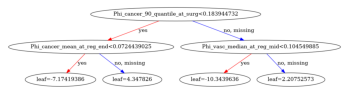

/home/johnpfeiffer/Venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/johnpfeiffer/Venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/johnpfeiffer/Venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/johnpfeiffer/

/home/johnpfeiffer/Venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/johnpfeiffer/Venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/johnpfeiffer/Venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/johnpfeiffer/

/home/johnpfeiffer/Venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/johnpfeiffer/Venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/johnpfeiffer/Venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/johnpfeiffer/

In [29]:
plt.figure(figsize=(12,12))
plot_tree(xgbc0, num_trees=0)
plt.show()

<Figure size 1440x2880 with 0 Axes>

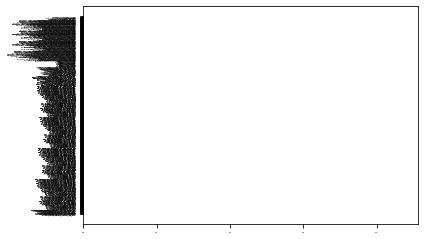

<Figure size 1440x2880 with 0 Axes>

In [30]:
plt.rcParams.update({'font.size': 2})
plt.barh(X_train.columns,xgbc0.feature_importances_, height=0.85)
plt.figure(figsize=(20,40)) 

In [28]:
y_validate

ISPY2_0103-L    False
ISPY2_0051-L    False
ISPY2_0444-L    False
ISPY2_0760-R    False
ISPY2_0118-R    False
ISPY2_0353-R    False
ISPY2_0164-R    False
ISPY2_0187-R    False
ISPY2_0173-R    False
ISPY2_0148-L    False
ISPY2_0132-R     True
ISPY2_0845-L    False
ISPY2_0533-R    False
ISPY2_0150-R    False
ISPY2_0028-R    False
ISPY2_0752-L     True
ISPY2_0177-L    False
ISPY2_0822-L    False
ISPY2_0106-L    False
ISPY2_0438-L    False
ISPY2_0190-R    False
Name: True, dtype: bool